Trying https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [1]:
pip list | grep tensorflow

tensorflow                    2.8.0
tensorflow-addons             0.16.1
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


### Import Libraries

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

In [2]:
!pip install -q -U tensorflow_addons
!pip3 install py-ecg-detectors
!pip install neurokit2

In [2]:
from numpy import array
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)
%matplotlib inline
import matplotlib.pyplot as plt 
from os import listdir 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll
import pywt

import neurokit2 as nk

from ecgdetectors import Detectors #for pantompkins
detectors = Detectors(500) #specify sampling rate

%load /content/arryhthmia_backend.py


In [3]:

def round_robin(RR_interval):

  RR_interval=RR_interval.tolist()
  wind_size = 100
  data_vect = []
  modified_data_vector = []
  ex_index = []

  #CREATE DATA VECTOR
  for i in tqdm(range(len(RR_interval))):

    if i < len(RR_interval):

      if len(RR_interval) >= i+wind_size:
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)
      else:
        RR_interval.extend(RR_interval[0:100])
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)

  return np.array(data_vect)

def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

def detect_r_peaks(patient_list,case,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'

    data_with_rr = pd.DataFrame()
    patient_col_id = []
    case_name = []
    mxx=0
    cnt=0
    mnn=90
    for i in tqdm(patient_list):
      # try:
        
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        rr_diff = np.append(0,rr_diff)

        mxx=max(len(rr_diff),mxx) #to check maximum number of rr intervals for any signal
        mnn=min(len(rr_diff),mnn)

        print(len(rrintervals),len(rr_diff))

        patient_col_id.append(i)
        case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)

        if(showplots):
          plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))
          plot_rr(rrintervals,rr_diff)
          print("DETRENDED")
          plot_rr(rrintervals,detrended_rri)
          
      # except:
      #   print("\nError in:",i)
    print("\n",case,"    ****Max****:",mxx)
    print("\n",case,"    ****Min****:",mnn,"\n")
    print("Total no. of RR Intervals in",case," class is:",cnt,"\n")
    data_with_rr['filename']=patient_col_id
    data_with_rr['label']=case_name
    return data_with_rr  #returning data containing RR Intervals with label

def append_r_peaks(patient_list,case,showplots=False):
    rr_ints=[]
    rri_with_patient_id = {}
    # rr_ints=np.array(rr_ints) 
    parent_folder = '/content/ECGDataDenoised/'
    data_with_rr = pd.DataFrame()
    patient_col_id = []
    # case_name = []
    cnt=0
    for i in tqdm(patient_list):
      try:
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        # rr_diff = np.append(0,rr_diff) #adding this 0 for equal size of RRi , hence to plot
        rr_ints = np.append(rr_ints,rr_diff)
        patient_col_id.append(i)
        # case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
        rri_with_patient_id[i]=detrended_rri
      except:
        print("\nError in:",i)

    print("Total no. of RR Intervals in",case," class is:",len(rr_ints),"\n")
    return rri_with_patient_id  #returning data containing RR Intervals with label

def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))



  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr


def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-2, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def get_base_model(categories=3):
  return keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[100], kernel_regularizer=regularizers.l2(0.001)),
    # keras.layers.Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 3 else keras.layers.Dense(5, activation='softmax'))                   
  ])


def get_resnet_model(categories=3): #original
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(64,kernels, stride, padding='same')(X)
    # out = keras.layers.ReLU()(out)
    # out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([100,1])
  X = keras.layers.Conv1D(64,kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

def train_1_fold(train,test,NN):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(7)

    save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights('weights.hdf5')
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    X_arhy_test = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   

    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)

    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

In [4]:
# from arryhthmia_backend import *

### Load Data

In [13]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [14]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [7]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [12]:
nsr_rri=append_r_peaks(nsr_files,"nsr")
afib_rri=append_r_peaks(afib_files,"afib")
afl_rri=append_r_peaks(afl_files,"afl")
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:41<00:00, 43.90it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1619/1779 [00:35<00:02, 58.09it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:38<00:00, 46.22it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:07<00:00, 57.14it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [9]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [15]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 467123.99it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 481681.51it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 6s 11ms/step - loss: 0.5708 - accuracy: 0.7497 - val_loss: 0.2534 - val_accuracy: 0.9060
Epoch 2/8
392/392 [==============================] - 3s 8ms/step - loss: 0.2532 - accuracy: 0.9057 - val_loss: 0.2865 - val_accuracy: 0.8833
Epoch 3/8
392/392 [==============================] - 3s 8ms/step - loss: 0.1309 - accuracy: 0.9531 - val_loss: 0.0747 - val_accuracy: 0.9727
Epoch 4/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0311 - accuracy: 0.9887 - val_loss: 0.0260 - val_accuracy: 0.9903
Epoch 5/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0197 - accuracy: 0.9925 - val_loss: 0.0488 - val_accuracy: 0.9813
Epoch 6/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0884 - accuracy: 0.9698 - val_loss: 0.1061 - val_accuracy: 0.9648
Epoch 7/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0570 - accuracy: 0.9799 - val_loss: 0.0371 - val_accuracy: 0.9878
Epoch 8/8
39

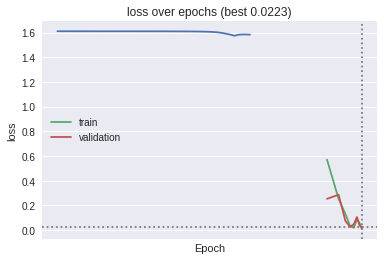

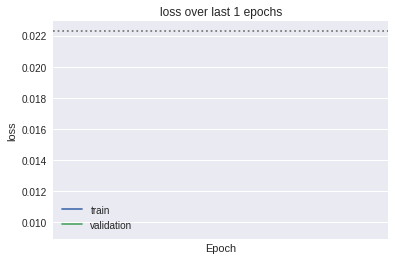

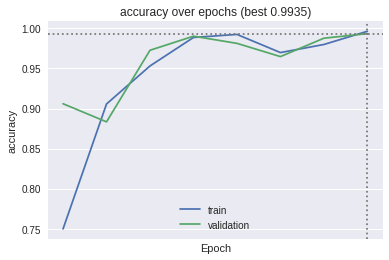

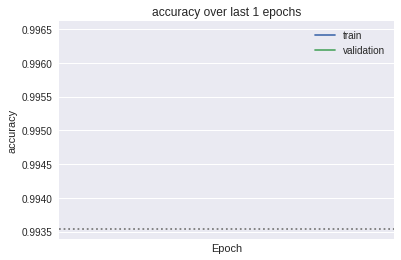


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 1s 5ms/step - loss: 0.0127 - accuracy: 0.9950
Confusion matrix, without normalization
[[924   0   0]
 [  0 908   3]
 [  2   9 939]]


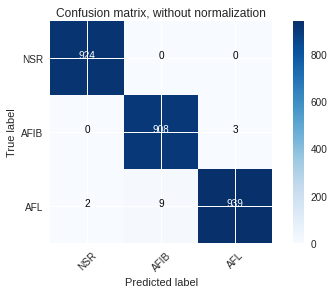


****** Validation data (unseen to model) *****

184/184 [==============================] - 1s 4ms/step - loss: 0.6947 - accuracy: 0.9153
Confusion matrix, without normalization
[[1902    0   51]
 [   0 1862   91]
 [  15  339 1599]]


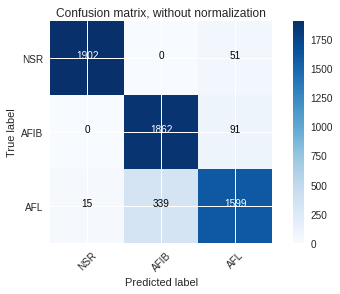

In [16]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)

# enumerate splits
count=1
for train, test in kfold.split(data):  

  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  train_1_fold(full_train_set,full_test_set,7)
  break
  #1 fold done call rest part in function to complete your k fold cv